Start this on the zedboard first
```bash
$ sudo python3 litex_server.py --devmem --devmem-offset 0x40000000
```

In [1]:
%pylab notebook
from struct import pack, unpack
from time import sleep
import sys
sys.path.append("../..")
from common import *
from scope_app import autoBitslip, autoIdelay, getSamples
from matplotlib.animation import FuncAnimation
rcParams["axes.grid"] = True

Populating the interactive namespace from numpy and matplotlib


# Setup SPI, reset and dump LTC2175 registers

In [4]:
r = conLitexServer('../build/csr.csv')
print("f_sample:", r.regs.lvds_f_sample_value.read() / 1e6, "MHz")

Connected to Port 1234
LTC2175 demonstrator 2019-10-25 13:46:43
f_sample: 117.600587 MHz


In [7]:
ltc_spi = LTC_SPI(r)
for i in range(5):
    print("{:2x}: {:02x}".format(i, ltc_spi.get_ltc_reg(i)))

ltc_spi.set_ltc_reg(0, 0x80)   # Software reset
# ltc_spi.set_ltc_reg(1, 0x10)   # Sleep mode
# ltc_spi.set_ltc_reg(1, 0x00)   # Waky waky

ltc_spi.setTp(1)
autoBitslip(r)
autoIdelay(r)

ltc_spi.set_ltc_reg(3, 0)   # Test pattern off
ltc_spi.set_ltc_reg(1, (1 << 5))   # Randomizer off, twos complement output

 0: 00
 1: 20
 2: 00
 3: 00
 4: 01
autoBitslip(): aligned after 0
autoIdelay(): min = 8, mean = 15, max = 22 idelays


# Play with bitslip / idelay parameters

### show status

In [ ]:
def print_frm():
    idel = r.regs.lvds_idelay_value.read()
    v = r.regs.lvds_frame_peek.read()
    print("ID: {:}  F: {:08b}".format(idel, v))
    for i in range(4):
        v = getattr(r.regs, 'lvds_data_peek{:}'.format(i)).read()
        print("{:}: {:016b}".format(i, v))
ltc_spi.setTp(1)
print_frm()

### bitslip until we get 0xF0 on frame_peek

In [ ]:
r.regs.lvds_bitslip_csr.write(1)
print_frm()

### IDELAY adjustments to find the eye limits

In [ ]:
r.regs.lvds_idelay_inc.write(1)
print_frm()

In [ ]:
r.regs.lvds_idelay_dec.write(1)
print_frm()

do a bitslip until we get 0x0F

### map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [ ]:
for ch in range(4):
    print("Channel {:d}".format(ch))
    for i in range(14):
        tpValue = 1 << i
        ltc_spi.setTp(tpValue)
        rVal = getattr(r.regs, 'lvds_data_peek{:d}'.format(ch)).read()
        print("{:016b} {:016b}".format(tpValue, rVal))    

# Read ADC sample

In [6]:
ltc_spi.set_ltc_reg(3, 0)   # Test pattern off
ltc_spi.set_ltc_reg(1, (1 << 5))   # Randomizer off, twos complement output

In [327]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek0.read()
print("0x{0:04x} 0b{0:016b}".format(rVal))
# Decode offset binary mode
print(twos_comp(rVal, 14))

0x3d79 0b0011110101111001
-647


# Read randomized ADC sample

In [ ]:
ltc_spi.set_ltc_reg(1, (1<<6))   # Randomizer on

In [ ]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

# Read acquisition memory

In [ ]:
hd(r.big_read(0x10000000, 0x400), 2, 1)

In [ ]:
r.regs.acq_trig_level.write(0)
print(hex(r.regs.acq_trig_level.read()))
r.regs.acq_trig_csr.write(1)

In [ ]:
close('all')
for i in range(4):
#     dat = array(r.big_read(0x10000000 + i * 0x01000000, 0x1000))
#     dat = twos_comps(dat >> 2, 14)
    dat = getSamples(r, i, 0x1000)
    plot(dat, label='ch ' + str(i), drawstyle='steps-post')
legend()

In [ ]:
r.regs.ctrl_bus_errors.read()

# Vector volt-meter

### Text mode

In [188]:
# Frequency / bandwidth setting
deci = 100
fcenter = 500.4e6
fSample = r.regs.lvds_f_sample_value.read()
ftw = int(((fcenter / fSample) % 1) * 2**32)
r.regs.vvm_ddc_ftw.write(ftw)
r.regs.vvm_ddc_deci.write(deci)

# Throw away N bits after CIC to avoid saturation with large deci factors
# This will change the scaling!
r.regs.vvm_ddc_shift.write(0)

# IIR result averaging filter smoothing factor (0 - 15)
r.regs.vvm_iir.write(15)

print('ddc_ftw', hex(r.regs.vvm_ddc_ftw.read()))
print('f_sample', fSample)
print('ddc_deci', r.regs.vvm_ddc_deci.read())
print('bw', 117.6e6 / deci)
print('iir_shift', r.regs.vvm_iir.read())

ddc_ftw 0x414cf26b
f_sample 117600599
ddc_deci 100
bw 1176000.0
iir_shift 15


In [190]:
print("Magnitude")
for i in range(4):
    print(getattr(r.regs, "vvm_mag{}".format(i)).read() / (1 << 21))
print("\nPhase")
for i in range(4):
    print(getInt32(getattr(r.regs, "vvm_phase{}".format(i)).read()) / (1 << 21))

Magnitude
0.628324031829834
0.5468730926513672
6.628036499023438e-05
5.14984130859375e-05

Phase
0.4450950622558594
0.778841495513916
-0.877342700958252
0.7256374359130859


### Live plot and record time serie

<IPython.core.display.Javascript object>


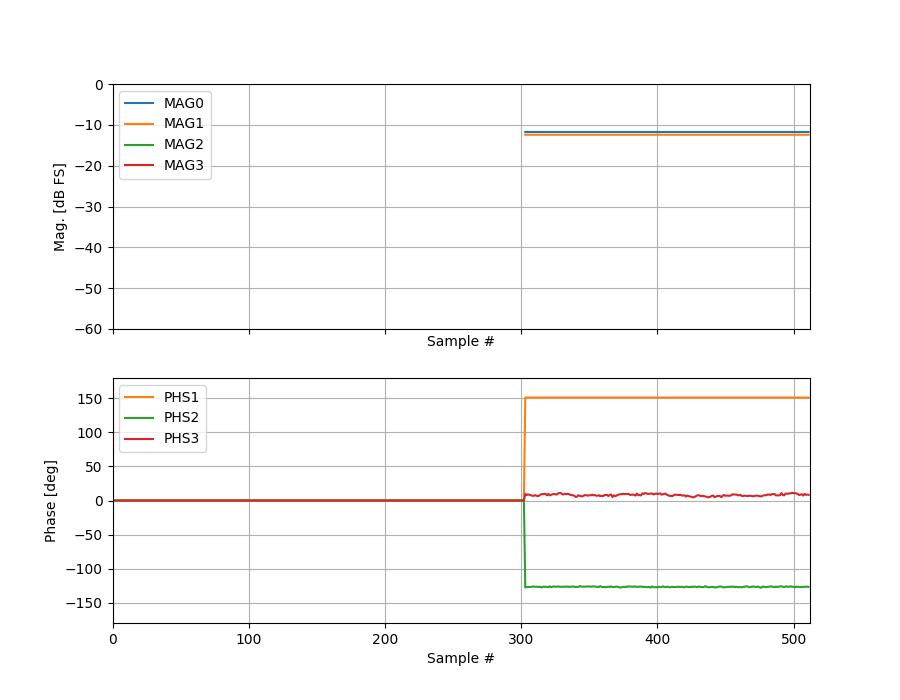

In [300]:
N = 512
close('all')
fig, axs = subplots(2, sharex=True, figsize=(9,7))
datms = zeros((N, 4))
datps = zeros((N, 3))
lms = []
lps = []
for i in range(datms.shape[1]):
    l, = axs[0].plot([], [], label="MAG{}".format(i))
    lms.append(l)

next(axs[1]._get_lines.prop_cycler)
for i in range(datps.shape[1]):
    l, = axs[1].plot([], [], label="PHS{}".format(i + 1))
    lps.append(l)

axs[0].set_ylim(-60, 0)
axs[0].set_ylabel("Mag. [dB FS]")
for ax in axs:
    ax.set_xlim(0, N)
    ax.set_xlabel("Sample #")
    ax.legend(loc="upper left")
ax.set_ylim(-180, 180)
ax.set_ylabel("Phase [deg]")
fig.tight_layout()

def upd(i):
    datms[:] = roll(datms, -1, 0)
    datps[:] = roll(datps, -1, 0)
    for i in range(4):
        val = getattr(r.regs, "vvm_mag{}".format(i)).read() / (1 << 21)
        datms[-1, i] = val
        lms[i].set_data(arange(datms.shape[0]), 20 * log10(datms[:, i]))
        
    for i in range(3):
        val = getattr(r.regs, "vvm_phase{}".format(i + 1)).read()
        val = getInt32(val) / (1 << 21) * 180
        datps[-1, i] = val
        lps[i].set_data(arange(datps.shape[0]), datps[:, i])
    
ani = FuncAnimation(fig, upd, interval=100)

In [291]:
20 * log10(0.5)

-6.020599913279624

In [ ]:
#savez_compressed("overnight_phase_22bit_1Hz", dat=dat)

### Plot recorded time series

<IPython.core.display.Javascript object>


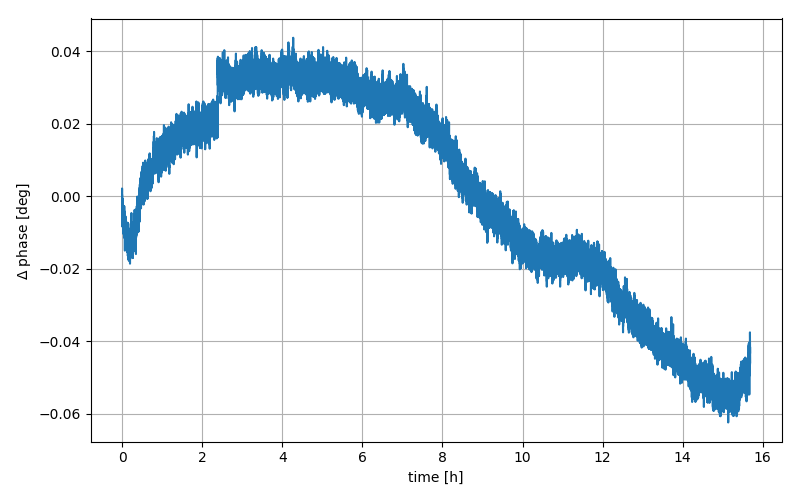

In [41]:
fName = "overnight_phase_22bit_1Hz.npz"
d = load(fName)['dat'][300:]
fig, ax = subplots(figsize=(8,5))
ax.plot(arange(len(d)) / 60 / 60, d - mean(d))
ax.set_xlabel('time [h]')
ax.set_ylabel('$\Delta$ phase [deg] ')
tight_layout()
savefig(fName.split('.')[0] + '.png', dpi=200)

# Demonstrate bit - mapping ...
of serdes lane bits to ADC sample words

In [ ]:
N_CHANNELS = 4
S = 8
D = N_CHANNELS * 2 + 1
data_outs = [arange(i * S, (i + 1) * S) for i in range(D)]
for i, d in enumerate(data_outs):
    print("lane", i, "bit", d)
print()
for i in range(N_CHANNELS):
    print("channel", i, myzip(data_outs[2 * i + 1], data_outs[2 * i])[2:])